# Experiment 6: rqlite + sqlite-vec

### RUN RQLITE BEFORE START
```
./rqlited -extensions-path=sqlite-vec.tar.gz exp6
```

In [2]:
import os

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import pyrqlite.dbapi2 as dbapi2
import struct

from tqdm.notebook import tqdm
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO

from face_alignment import align


In [3]:
# Load the CSV file
df = pd.read_csv("dataset/IMDb-Face_clean_unique.csv")
df = df.head(100)


In [4]:
# Define preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load face embedding model
model_face_embedding = torch.hub.load('otroshi/edgeface', 'edgeface_s_gamma_05', source='github', pretrained=True)

# Move the model to the GPU if available
model_face_embedding = model_face_embedding.to(device)

# Set model to eval
model_face_embedding.eval()

print(f"Model is loaded on {device}")


Using cache found in /root/.cache/torch/hub/otroshi_edgeface_main


Model is loaded on cuda


In [6]:
# Load YOLO model
model_yolo = YOLO("models/yolov11s-face.pt")


In [7]:
# Connect to the database
connection = dbapi2.connect(
    host='localhost',
    port=4001,
)

# Check SQLite and sqlite-vec version
conn = connection.cursor()
conn.execute("SELECT sqlite_version(), vec_version()")
sqlite_version, vec_version = conn.fetchone()
print(f"SQLite Version: {sqlite_version}, sqlite-vec Version: {vec_version}")


SQLite Version: 3.46.1, sqlite-vec Version: v0.1.6


In [8]:
# Create virtual table for vector storage
conn.execute("""
CREATE VIRTUAL TABLE IF NOT EXISTS images USING vec0(
    name TEXT, 
    file_dir TEXT, 
    embedding float[512] distance_metric=cosine
);
""")


In [9]:
# Function to serialize embeddings
def serialize_f32(vector):
    """Serialize a list of floats into raw bytes for storage."""
    return struct.pack("%sf" % len(vector), *vector)


In [12]:
# Create Index Database

# for index, row in sample_df.iterrows():
for index, row in tqdm(df.iterrows(), desc="Processing images", total=len(df)):
    image_path = os.path.join("dataset", "IMDb-Face_clean_unique", "images", row["index"], row["image"])  # Construct the file path

    # Load the image with OpenCV
    image = cv2.imread(image_path)

    if image is not None:
        # Extract height and width from the row
        height, width = map(int, row["height width"].split())  # Assuming height and width are stored as space-separated values

        # Resize the image based on the given height and width
        resized_image = cv2.resize(image, (width, height))

        # Run YOLO inference
        results = model_yolo(resized_image, device=device, verbose=False)  

        # Extract bounding boxes
        if len(results) > 0:
            boxes = results[0].boxes  # Get detected bounding boxes

            if len(boxes) > 0:
                # Extract CSV face coordinates
                x1_csv, y1_csv, x2_csv, y2_csv = map(int, row["rect"].split())

                # Compute CSV face center
                cx_csv = (x1_csv + x2_csv) / 2
                cy_csv = (y1_csv + y2_csv) / 2

                closest_box = None
                min_distance = float("inf")

                # Iterate over detected faces
                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

                    # Compute center of detected face
                    cx_det = (x1 + x2) / 2
                    cy_det = (y1 + y2) / 2

                    # Compute Euclidean distance
                    distance = np.sqrt((cx_det - cx_csv) ** 2 + (cy_det - cy_csv) ** 2)

                    # Update the closest face
                    if distance < min_distance:
                        min_distance = distance
                        closest_box = (int(x1), int(y1), int(x2), int(y2))

                # Crop the closest face
                if closest_box:
                    x1, y1, x2, y2 = closest_box

                    margin = 30
                    h, w, _ = resized_image.shape  # Get image dimensions

                    # Clip coordinates to stay within image bounds
                    x1 = max(0, x1 - margin)
                    y1 = max(0, y1 - margin)
                    x2 = min(w, x2 + margin)
                    y2 = min(h, y2 + margin)

                    face_image = resized_image[y1:y2, x1:x2]

                    # Plot Image
                    # plt.imshow(face_image)
                    # plt.axis("off")  # Hide axis
                    # plt.show()

                    # Get Embedding
                    # Convert the OpenCV image (BGR) to PIL image (RGB)
                    pil_image = Image.fromarray(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB))
                    aligned = align.get_aligned_face(None, pil_image) # align face

                    # Check If alignment result good
                    if aligned is not None:
                        
                        # Plot Image
                        # plt.imshow(aligned)
                        # plt.axis("off")  # Hide axis
                        # plt.show()

                        transformed_input = transform(aligned).unsqueeze(0).to(device) # preprocessing

                        # extract embedding
                        face_embedding = model_face_embedding(transformed_input).cpu().detach().numpy().flatten()

                        # save into database
                        conn.execute(
                            "INSERT INTO images (rowid, name, file_dir, embedding) VALUES (?, ?, ?, ?)",
                            (None, row["name"], image_path, serialize_f32(face_embedding)),
                        )

print("Database updated successfully!")


Processing images:   0%|          | 0/100 [00:00<?, ?it/s]

Face detection Failed due to error.
list index out of range
Face detection Failed due to error.
list index out of range
Face detection Failed due to error.
list index out of range
Face detection Failed due to error.
list index out of range
Face detection Failed due to error.
list index out of range
Face detection Failed due to error.
list index out of range
Face detection Failed due to error.
list index out of range
Database updated successfully!


In [13]:
# Function to find similar images
def find_similar_images(query_embedding, top_n=5):
    query_vector = serialize_f32(query_embedding)
    rows = conn.execute(
        """
        SELECT rowid, name, file_dir, distance
        FROM images
        WHERE embedding MATCH ?
        AND k = ?
        ORDER BY distance
        """,
        (query_vector, top_n),
    ).fetchall()
    
    return rows


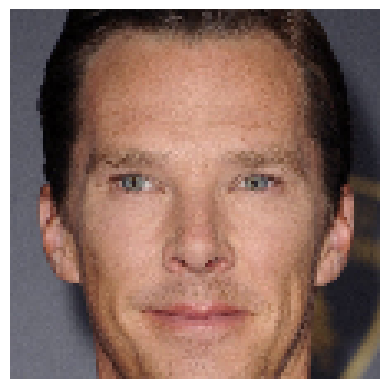

Top similar images:
(2, 'Benedict_Cumberbatch', 'dataset/IMDb-Face_clean_unique/images/nm1212722/1.jpg', 0.16082042455673218)


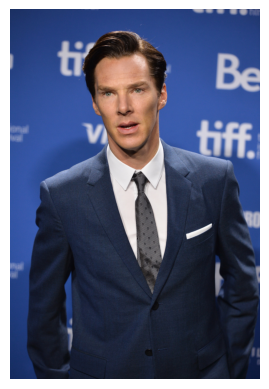

(1, 'Benedict_Cumberbatch', 'dataset/IMDb-Face_clean_unique/images/nm1212722/1.jpg', 0.16082042455673218)


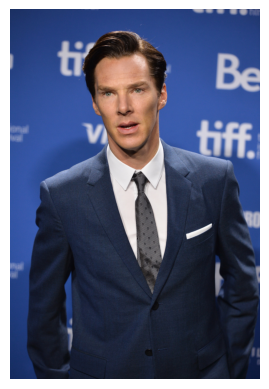

(73, 'Michael_Caton-Jones', 'dataset/IMDb-Face_clean_unique/images/nm0001994/1.jpg', 0.6835537552833557)


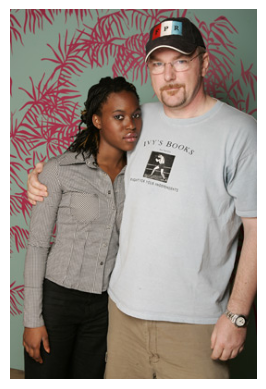

(65, 'Jed', 'dataset/IMDb-Face_clean_unique/images/nm1082505/1.jpg', 0.7066330909729004)


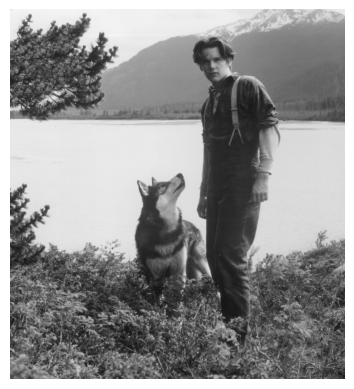

(78, 'Kelly_Marcel', 'dataset/IMDb-Face_clean_unique/images/nm2813876/1.jpg', 0.7260940074920654)


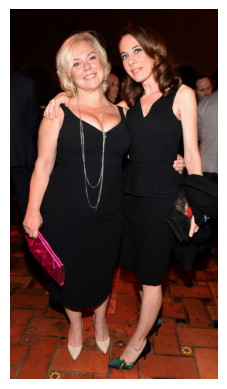

In [15]:
# Example: Query with a specific face embedding (e.g., first embedding in the list)
# query_embedding = embeddings_list[0]  # Let's use the first image's embedding as the query
image_path = "test_images/benedict cumberbatch_1.jpg"
input_image = cv2.imread(image_path)

# Convert the image to RGB
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

pil_image = Image.fromarray(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
aligned = align.get_aligned_face(None, pil_image)  # align face

# Plot the image
plt.imshow(aligned)
plt.axis("off")  # Hide axis
plt.show()

if aligned is not None:
    transformed_input = transform(aligned).unsqueeze(0).to(device)  # preprocessing
    face_embedding = model_face_embedding(transformed_input).cpu().detach().numpy().flatten()


    query_embedding = face_embedding
    query_results = find_similar_images(query_embedding)

    print("Top similar images:")
    for query in query_results:
        print(query)

        image = cv2.imread(query[2])

        # Plot Image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")  # Hide axis
        plt.show()
else:
    print("invalid alignment")
